# Facies Classification Solution By Team_BGC

Note: Current version is not the final submission. We are testing our ideas and approaches to the hidden well.
All the details will be updated when the code is working fine!


Cheolkyun Jeong and Ping Zhang From Team_BGC

## Import Header

In [15]:
##### import basic function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score

## 1. Data Prepocessing

1) Filtered data preparation

After the initial data validation, we figure out the NM_M input is a key differentiator to group non-marine stones (sandstone, c_siltstone, and f_siltstone) and marine stones (marine_silt_shale, mudstone, wakestone, dolomite, packstone, and bafflestone) in the current field. Our team decides to use this classifier aggressively and prepare a filtered dataset which cleans up the outliers.

In [16]:
# Input file paths
facies_vector_path = 'facies_vectors.csv'
train_path = 'training_data.csv'
test_path = 'validation_data_nofacies.csv'
# Read training data to dataframe
training_data = pd.read_csv(train_path)

In [17]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

# Fitering out some outliers
j = []
for i in range(len(training_data)):
    if ((training_data['NM_M'].values[i]==2)and ((training_data['Facies'].values[i]==1)or(training_data['Facies'].values[i]==2)or(training_data['Facies'].values[i]==3))):
        j.append(i)
    elif((training_data['NM_M'].values[i]==1)and((training_data['Facies'].values[i]!=1)and(training_data['Facies'].values[i]!=2)and(training_data['Facies'].values[i]!=3))):
        j.append(i)

training_data_filtered = training_data.drop(training_data.index[j])

print(np.shape(training_data_filtered))


(3179, 12)


## 2. Feature Selection

Log Plot of Facies

### Filtered Data

SS      259
CSiS    732
FSiS    599
SiSh    179
MS      206
WS      460
D        97
PS      486
BS      161
Name: Facies, dtype: int64

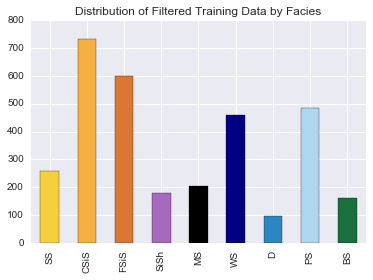

In [18]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts_filtered = training_data_filtered['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts_filtered.index = facies_labels

facies_counts_filtered.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Filtered Training Data by Facies')
#facies_counts_filtered
training_data_filtered.columns

facies_counts_filtered

### Filtered facies

In [19]:
correct_facies_labels_filtered = training_data_filtered['Facies'].values
feature_vectors_filtered = training_data_filtered.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors_filtered.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000
mean,65.975960,0.643302,3.620791,13.396139,3.733593,1.499843,0.523636
std,30.781949,0.242851,5.161355,7.670558,0.897148,0.500079,0.283774
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.724500,0.491000,1.200000,8.300000,3.101000,1.000000,0.281500
50%,65.671000,0.624000,3.500000,12.065000,3.586000,1.000000,0.529000
75%,79.612500,0.816500,6.471500,16.328000,4.300000,2.000000,0.767000
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [20]:
from sklearn import preprocessing
scaler_filtered = preprocessing.StandardScaler().fit(feature_vectors_filtered)
scaled_features_filtered = scaler_filtered.transform(feature_vectors_filtered)

In [21]:
from sklearn.cross_validation import train_test_split

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
        scaled_features_filtered, correct_facies_labels_filtered, test_size=0.3, random_state=16)

In [22]:
X_train_full, X_test_zero, y_train_full, y_test_full = train_test_split(
        scaled_features_filtered, correct_facies_labels_filtered, test_size=0.0, random_state=42)

## 3. Prediction Model

Accuracy

In [23]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [24]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [25]:
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from classification_utilities import display_cm, display_adj_cm

## 4. DNN using Tensorflow

In [27]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
# Prepare the hidden well data
X_unknown = scaler_filtered.transform(well_features)

Filtered Data Model

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

# Specify that all features have real-value data
feature_columns_filtered = [tf.contrib.layers.real_valued_column("", dimension=7)]

# Build 3 layer DNN with 7, 17, 10 units respectively.
classifier_filtered = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns_filtered,
                                            hidden_units=[7, 17, 10],
                                            n_classes=10)

# Fit model.
classifier_filtered.fit(x=X_train_filtered,
               y=y_train_filtered,
               steps=5000)


y_predict_filtered = []
predictions = classifier_filtered.predict(x=X_test_filtered)

for i, p in enumerate(predictions):
    y_predict_filtered.append(p)
    #print("Index %s: Prediction - %s, Real - %s" % (i + 1, p, y_test_filtered[i]))

# Evaluate accuracy.
accuracy_score_filtered = classifier_filtered.evaluate(x=X_test_filtered, y=y_test_filtered)["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score_filtered))

cv_conf_dnn = confusion_matrix(y_test_filtered, y_predict_filtered)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_dnn))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_dnn, adjacent_facies))
display_cm(cv_conf_dnn, facies_labels,display_metrics=True, hide_zeros=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'tf_random_seed': None, '_environment': 'local', '_task_id': 0, '_num_ps_replicas': 0, 'save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000CE43860>, 'save_checkpoints_secs': 600, 'keep_checkpoint_every_n_hours': 10000, '_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'save_summary_steps': 100, '_is_chief': True, '_evaluation_master': '', '_task_type': None, 'keep_checkpoint_max': 5}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and b

Result from DNN

In [30]:
classifier_filtered.fit(x=X_train_full,
               y=y_train_full,
               steps=10000)
predictions = classifier_filtered.predict(X_unknown)
y_predict_filtered = []
for i, p in enumerate(predictions):
    y_predict_filtered.append(p)
well_data['Facies'] = y_predict_filtered
well_data
well_data.to_csv('predict_result_dnn.csv')

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using